# UK Police Stop-and-Searches Python Code

### Please note that this notebook is made up of several scripts which have been used to gather and model the data. Therefore the kernel should be restarted before running each of the sections listed below:

1. [Scraping Script](#1.-Scraping-Script)
2. [Inspection of the log file](#2.-Inspection-of-the-log-file)
3. [Notebook for Tidying Locational Data](#3.-Notebook-for-Tidying-Locational-Data)
4. [Identify local authority](#4.-Identify-local-authority)
5. [Creating temporal features](#5.-Creating-temporal-features)
6. [Exploratory Analysis and Plotting](#6.-Exploratory-Analysis-and-Plotting)
7. [Choropleth](#7.-Choropleth)
8. [Machine Learning Script](#8.-Machine-Learning-Script)


# 1. Scraping Script

## Section below imports packages and defines the connector

In [1]:
import requests,os,time
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm

In [11]:
### Define our Connector

def ratelimit(dt):
    "A function that handles the rate of your calls."
    time.sleep(dt) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=250,waiting_time=0.07):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    self.waiting_time = waiting_time # define simple rate_limit parameter.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit(self.waiting_time)
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit(self.waiting_time)
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

## Define various variables, url, etc.

In [7]:
logfile = 'LOG_test_run.csv'

#For scrape of force names
forces_url = 'https://data.police.uk/api/forces'
forces_job_name = 'forces_job'

#For scrape of stop and searches data
scrape_base_url = 'https://data.police.uk/api/stops-force?force='
scrape_job_name = 'scrape_job'
date_from = '2016-08'
date_to = '2019-05'

#For save as csv
csv_name = 'DATA_test_run.csv'

## The scrape

In [4]:
connector = Connector(logfile, overwrite_log=True)

In [5]:
#Extract police force data
response,call_id = connector.get(forces_url,forces_job_name)
Forces = pd.DataFrame(response.json())
Forces.head()

,id,name
0,avon-and-somerset,Avon and Somerset Constabulary
1,bedfordshire,Bedfordshire Police
2,cambridgeshire,Cambridgeshire Constabulary
3,cheshire,Cheshire Constabulary
4,city-of-london,City of London Police


In [6]:
len(Forces)

44

In [12]:
dates = pd.date_range(date_from,date_to , freq='1M')
dates = [d.strftime('%Y-%m') for d in dates]
List = []

for j in tqdm(Forces.id):
    for i in tqdm(dates):
        get_url = scrape_base_url + j +'&date='+i
        response,call_id = connector.get(get_url,scrape_job_name)
        response.text
        jason = response.json()
        data = pd.DataFrame(jason)
        data['Force'] = j
        List.append(data)

In [13]:
Data = pd.concat(List, sort=False)
Data.reset_index(drop=True)

,age_range,datetime,gender,involved_person,legislation,location,object_of_search,officer_defined_ethnicity,operation,operation_name,outcome,outcome_linked_to_object_of_search,outcome_object,removal_of_more_than_outer_clothing,self_defined_ethnicity,type,Force
0,None,2016-08-11T07:43:29+00:00,None,True,None,"{'latitude': '51.461000', 'street': {'id': 543...",None,None,None,None,,None,"{'id': '', 'name': ''}",None,None,Person search,avon-and-somerset
1,None,2016-08-11T07:43:29+00:00,None,True,None,None,None,None,None,None,,None,"{'id': '', 'name': ''}",None,None,Person search,avon-and-somerset
2,None,2016-08-20T05:07:31+00:00,Female,True,Misuse of Drugs Act 1971 (section 23),None,Controlled drugs,White,False,None,False,None,"{'id': 'nothing', 'name': 'Nothing found - No ...",False,White - White British (W1),Person search,avon-and-somerset
3,18-24,2016-08-20T14:18:32+00:00,Male,True,Misuse of Drugs Act 1971 (section 23),None,Controlled drugs,White,False,None,False,None,"{'id': 'nothing', 'name': 'Nothing found - No ...",False,White - White British (W1),Person search,avon-and-somerset
4,18-24,2016-08-10T16:44:20+00:00,None,True,Misuse of Drugs Act 1971 (section 23),"{'latitude': '51.004561', 'street': {'id': 529...",Controlled drugs,White,None,None,Offender given drugs possession warning,None,"{'id': 'drugs', 'name': 'Offender given drugs ...",None,White - White British (W1),Person search,avon-and-somerset
5,over 34,2016-08-01T03:30:44+00:00,Male,True,None,None,None,None,None,None,,None,"{'id': '', 'name': ''}",None,None,Person search,avon-and-somerset
6,10-17,2016-08-01T04:09:15+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),None,Article for use in theft,White,False,None,False,None,"{'id': 'nothing', 'name': 'Nothing found - No ...",False,White - White British (W1),Person search,avon-and-somerset
7,18-24,2016-08-01T04:09:15+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),None,Article for use in theft,White,None,None,False,None,"{'id': 'nothing', 'name': 'Nothing found - No ...",False,White - White British (W1),Person search,avon-and-somerset
8,over 34,2016-08-01T08:26:29+00:00,Male,True,Misuse of Drugs Act 1971 (section 23),None,Controlled drugs,Black,None,None,False,None,"{'id': 'nothing', 'name': 'Nothing found - No ...",None,Black or Black British - Caribbean (B1),Person search,avon-and-somerset
9,over 34,2016-08-01T12:21:18+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),"{'latitude': '51.456751', 'street': {'id': 543...",None,White,False,None,Suspect summonsed to court,None,"{'id': 'summonsed', 'name': 'Suspect summonsed...",False,White - Any other White ethnic background (W9),Person search,avon-and-somerset


In [14]:
Data['outcome_object']

0                                {'id': '', 'name': ''}
1                                {'id': '', 'name': ''}
2     {'id': 'nothing', 'name': 'Nothing found - No ...
3     {'id': 'nothing', 'name': 'Nothing found - No ...
4     {'id': 'drugs', 'name': 'Offender given drugs ...
5                                {'id': '', 'name': ''}
6     {'id': 'nothing', 'name': 'Nothing found - No ...
7     {'id': 'nothing', 'name': 'Nothing found - No ...
8     {'id': 'nothing', 'name': 'Nothing found - No ...
9     {'id': 'summonsed', 'name': 'Suspect summonsed...
10    {'id': 'summonsed', 'name': 'Suspect summonsed...
11         {'id': 'arrest', 'name': 'Suspect arrested'}
12    {'id': 'nothing', 'name': 'Nothing found - No ...
13          {'id': 'local', 'name': 'Local resolution'}
14          {'id': 'local', 'name': 'Local resolution'}
15                               {'id': '', 'name': ''}
16    {'id': 'drugs', 'name': 'Offender given drugs ...
17    {'id': 'nothing', 'name': 'Nothing found -

In [15]:
Data.to_csv(csv_name, index=False)

# 2. Inspection of the log file

## Importing packages

In [3]:
import requests,os,time
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [4]:
plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Examing Log

In [5]:
# Data = pd.read_csv('https://github.com/mathiasbruun/SDS19-Exam-Project/blob/master/Data_2018_csv.zip')
# url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/Data_2018_csv.zip'
url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/All_Data_Aug_22_11-15_attempt.csv'
log_df = pd.read_csv(url, sep=';')

In [6]:
log_df.head()

,id,project,connector_type,t,delta_t,url,redirect_url,response_size,response_code,success,error
0,0,job,requests,1.566465e+09,-0.258425,https://data.police.uk/api/stops-force?force=a...,https://data.police.uk/api/stops-force?force=a...,265866,200,True,NaN
1,1,job,requests,1.566465e+09,-0.047834,https://data.police.uk/api/stops-force?force=a...,https://data.police.uk/api/stops-force?force=a...,233765,200,True,NaN
2,2,job,requests,1.566465e+09,-0.048873,https://data.police.uk/api/stops-force?force=a...,https://data.police.uk/api/stops-force?force=a...,300582,200,True,NaN
3,3,job,requests,1.566465e+09,-0.039609,https://data.police.uk/api/stops-force?force=a...,https://data.police.uk/api/stops-force?force=a...,323127,200,True,NaN
4,4,job,requests,1.566465e+09,-0.040854,https://data.police.uk/api/stops-force?force=a...,https://data.police.uk/api/stops-force?force=a...,322286,200,True,NaN


In [7]:
len(log_df)

1496

In [8]:
# Convert the time column 't' to datetime 
#log_df['dt'] = log_df.t.apply(datetime.datetime.fromtimestamp)
log_df['dt'] = pd.to_datetime(log_df.t,unit='s')

C:\Users\krist\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


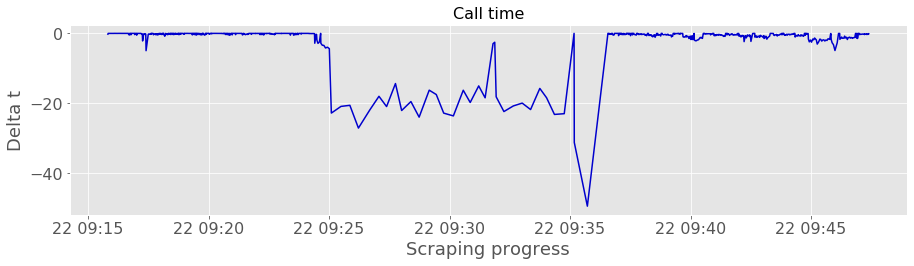

In [9]:
# Plot the time it took to make the call
plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t, color='mediumblue')
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')
plt.gcf().subplots_adjust(bottom=0.22)
plt.title('Call time')
plt.savefig('time to make the call.png')


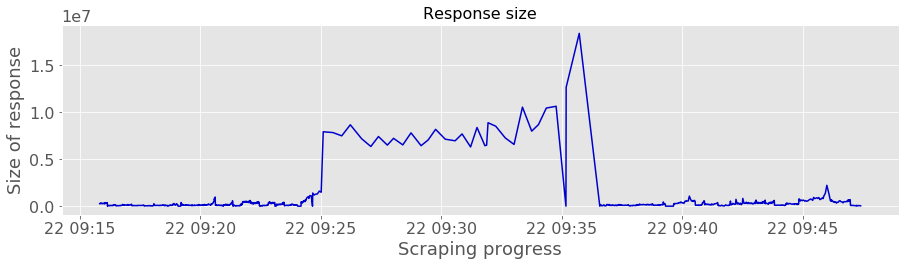

In [10]:
# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size, color='mediumblue')
plt.gcf().subplots_adjust(bottom=0.22)
plt.title('Response size')
plt.savefig('response size.png')

In [12]:
##Counting errors
log_df.success.value_counts()

True    1496
Name: success, dtype: int64

# 3. Notebook for Tidying Locational Data

Intended for loading and working with the raw dataframe to avoid having to scrape all the data each time. 

## Importing and loading stuff

In [1]:
import requests,os,time,datetime,json,ast
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/data_16-07_19_04.zip'
out_csv = "DataFrame_16-19_with_dicts.csv"

In [12]:
org_raw_data = pd.read_csv(url, compression='zip', na_values='NaN', low_memory=False)
raw_data = org_raw_data.copy()

## Working with the data

In [13]:
# Defining empty dict entries
nan_loc_val = {'latitude': None, 'street': {'id': None, 'name': None}, 'longitude': None}
nan_outcome_val = {'id': None, 'name': None}

In [14]:
#Transforming strings to dicts
raw_data['location_as_dict'] = [ast.literal_eval(i) if pd.notnull(i) == True else nan_loc_val for i in tqdm(raw_data['location'])]
raw_data['outcome_object_as_dict'] = [ast.literal_eval(i) if pd.notnull(i) == True else nan_val for i in tqdm(raw_data['outcome_object'])]

In [15]:
loc_keys = list(raw_data['location_as_dict'][1].keys())
obj_keys = list(raw_data['outcome_object_as_dict'][1].keys())
street_keys = list(raw_data['location_as_dict'][1]['street'].keys())

In [16]:
#Splitting into columns
for key in tqdm(loc_keys):
    raw_data['{}'.format(key)] = [raw_data['location_as_dict'][i][key] for i in tqdm(range(len(raw_data['location_as_dict'])))]

for key in tqdm(obj_keys):
    raw_data['outcome_object_{}'.format(key)] = [raw_data['outcome_object_as_dict'][i][key] for i in tqdm(range(len(raw_data['outcome_object_as_dict'])))]


In [17]:
for key in tqdm(street_keys):
    raw_data.insert(loc = raw_data.columns.get_loc('street')+1, column='street_{}'.format(key), value=[raw_data['location_as_dict'][i]['street'][key] for i in tqdm(range(len(raw_data['outcome_object_as_dict'])))])

## Remove unnecessary columns

In [18]:
#Removing str columns as intermediary columns
tidy_data = raw_data.drop(columns= ['location','outcome_object','street','location_as_dict','outcome_object_as_dict'])

## Save new dataframe

In [19]:
tidy_data.to_csv(out_csv,index = False)

# 4. Identify local authority

This notebook takes a dataframe with latitude and longitude values and estimates which UK local authority the point falls under by finding the shortest distance to a local authority coordinate as given by the UK ONS data set loaded below.

In [7]:
#Importing stuff
import requests,os,time,itertools
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm
from math import sin, cos, sqrt, atan2, radians
import multiprocessing as mp
from multiprocessing import get_context

In [3]:
#Giving necessary information

#Local path to ONS data set on local authorities
local_path = r'C:\Users\Troel\Downloads\Local_Authority_Districts_December_2017_Super_Generalised_Clipped_Boundaries_in_Great_Britain.csv'

#Dataset to load
data_path = r"C:\Users\Troel\Lecture slides etc\Exam\Ny mappe\SDS19-Exam-Project\DataFrame_16-19_with_dicts.csv"

#Save dataset as
out_csv = "16_19_data_with_local_auth.csv"

In [4]:
org_raw_data = pd.read_csv(data_path, sep=',', low_memory = False)
raw_data = org_raw_data.copy()

In [38]:
#Defining our function
#The function uses variations of trigonometry to calculate the distance between two points on 
#the surface of the Earth. h/t "Michael0x2a". For further info see:
#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

df = pd.read_csv(local_path, sep=',')
df = df[["lad17cd","lad17nm","long","lat"]].copy()
# approximate radius of earth in km
R = 6373.0
from math import sin, cos, sqrt, atan2, radians


def loc_aut_from_dist(lat,long):
    loc = df.loc
    notnull = pd.notnull
    if notnull(lat) == True:

        lat_point = radians(lat)
        long_point = radians(long)

        df['lat_dist'] = [radians(i)-lat_point for i in df['lat']]
        df['long_dist'] = [radians(i)-long_point for i in df['long']]

        df['1st'] = [sin(i/ 2)**2 for i in df['lat_dist']]
        df['2nd'] = [cos(lat_point) * cos(radians(i)) for i in df['long']]
        df['3rd'] = [sin(i/ 2)**2 for i in df['long_dist']]
        df['a'] = (df['1st'] + df['2nd'] * df['3rd'])
        df['c'] = [2 * atan2(sqrt(i), sqrt(1 - i)) for i in df['a']]

        df['distance'] = [R * i for i in df['c']]

        closest_local_authority = loc[df['distance'] == df['distance'].min()]['lad17cd']
        return list(closest_local_authority)[0],df['distance'].min()
    else:
        return None,None

In [40]:
raw_data['nearest_local_auth'] = [loc_aut_from_dist(lat,long)[0] for lat,long in tqdm(zip(raw_data['latitude'],raw_data['longitude']),total=len(raw_data['latitude']))]

In [ ]:
raw_data['dist_to_local_auth'] = [loc_aut_from_dist(lat,long)[1] for lat,long in tqdm(zip(raw_data['latitude'],raw_data['longitude']),total=len(raw_data['latitude']))]

In [47]:
raw_data.to_csv(out_csv,index = False)

# 5. Creating temporal features

In [10]:
import requests,os,time
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm

In [16]:
url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/16_19_data_with_local_auth.zip'
data = pd.read_csv(url, low_memory=False)

In [17]:
# Creating temporal features hours and month
data['datetime']=pd.to_datetime(data['datetime'])
data['month']=data['datetime'].dt.month
data['hour']=data['datetime'].dt.hour

In [18]:
data_local_path = r"C:\Users\krist\OneDrive\Dokumenter\GitHub\SDS19-Exam-Project\16_19_data_with_local_auth_time.csv"
out_csv = "16_19_data_with_local_auth_time.csv"

In [19]:
data.to_csv(out_csv, index=False)

In [21]:
data.head()

,age_range,datetime,gender,involved_person,legislation,object_of_search,officer_defined_ethnicity,operation,operation_name,outcome,...,Force,latitude,street_name,street_id,longitude,outcome_object_id,outcome_object_name,nearest_local_auth,month,hour
0,18-24,2016-07-01 03:36:40+00:00,Female,True,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,NaN,Suspect summonsed to court,...,avon-and-somerset,51.472770,On or near The Avenue,545646.0,-2.633822,summonsed,Suspect summonsed to court,E06000023,7,3
1,18-24,2016-07-01 03:36:40+00:00,Female,True,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,NaN,False,...,avon-and-somerset,51.472770,On or near The Avenue,545646.0,-2.633822,nothing,Nothing found - No further action,E06000023,7,3
2,18-24,2016-07-01 03:36:40+00:00,Female,True,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,NaN,False,...,avon-and-somerset,51.472770,On or near The Avenue,545646.0,-2.633822,nothing,Nothing found - No further action,E06000023,7,3
3,10-17,2016-07-01 05:20:55+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,White,False,NaN,False,...,avon-and-somerset,51.013992,On or near Shopping Area,530193.0,-3.101950,nothing,Nothing found - No further action,E07000190,7,5
4,25-34,2016-07-01 07:21:51+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,Other,False,NaN,False,...,avon-and-somerset,51.080631,On or near West Lane,531254.0,-2.612072,nothing,Nothing found - No further action,E07000187,7,7


# 6. Exploratory Analysis and Plotting

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np

plt.style.use('ggplot')

In [2]:
url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/Data_with_mean_income_population.zip'
df = pd.read_csv(url, compression = 'zip', low_memory = False)

In [3]:
df.head()

,age_range,datetime,gender,involved_person,legislation,object_of_search,officer_defined_ethnicity,operation,operation_name,outcome,...,street_id,longitude,outcome_object_id,outcome_object_name,nearest_local_auth,month,hour,Night_dummy,mean_income,mean_population
0,18-24,2016-07-01 03:36:40+00:00,Female,True,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,NaN,Suspect summonsed to court,...,545646.0,-2.633822,summonsed,Suspect summonsed to court,E06000023,7,3,1,17274.333333,450132.333333
1,18-24,2016-07-01 03:36:40+00:00,Female,True,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,NaN,False,...,545646.0,-2.633822,nothing,Nothing found - No further action,E06000023,7,3,1,17274.333333,450132.333333
2,18-24,2016-07-01 03:36:40+00:00,Female,True,Misuse of Drugs Act 1971 (section 23),Controlled drugs,White,False,NaN,False,...,545646.0,-2.633822,nothing,Nothing found - No further action,E06000023,7,3,1,17274.333333,450132.333333
3,10-17,2016-07-01 05:20:55+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,White,False,NaN,False,...,530193.0,-3.101950,nothing,Nothing found - No further action,E07000190,7,5,1,18759.333333,114373.000000
4,25-34,2016-07-01 07:21:51+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,Other,False,NaN,False,...,531254.0,-2.612072,nothing,Nothing found - No further action,E07000187,7,7,1,19024.666667,112092.666667


In [4]:
df['success'] = ~df.loc[:,'outcome'].isin(['A no further action disposal', 'False'])

df = df.loc[:,['age_range', 'gender', 'object_of_search', 'officer_defined_ethnicity', 
               'type', 'success','Force','hour', 'month']]

df = df.dropna()

In [5]:
df.head()

,age_range,gender,object_of_search,officer_defined_ethnicity,type,success,Force,hour,month
0,18-24,Female,Controlled drugs,White,Person search,True,avon-and-somerset,3,7
1,18-24,Female,Controlled drugs,White,Person search,False,avon-and-somerset,3,7
2,18-24,Female,Controlled drugs,White,Person search,False,avon-and-somerset,3,7
3,10-17,Male,Articles for use in criminal damage,White,Person search,False,avon-and-somerset,5,7
4,25-34,Male,Stolen goods,Other,Person search,False,avon-and-somerset,7,7


In [6]:
# Crosstab with "normalize = 'index'". 
df_percent = pd.crosstab(df.age_range, df.success,
                         normalize = 'index').rename_axis(None)

# Multiply all percentages by 100 for graphing. 
df_percent *= 100
df_percent.sort_index()
df_percent = df_percent.loc[['under 10', '10-17', '18-24', '25-34', 'over 34'], :]
df_percent

success,False,True
under 10,75.000000,25.000000
10-17,76.681273,23.318727
18-24,64.589728,35.410272
25-34,64.602077,35.397923
over 34,68.494542,31.505458


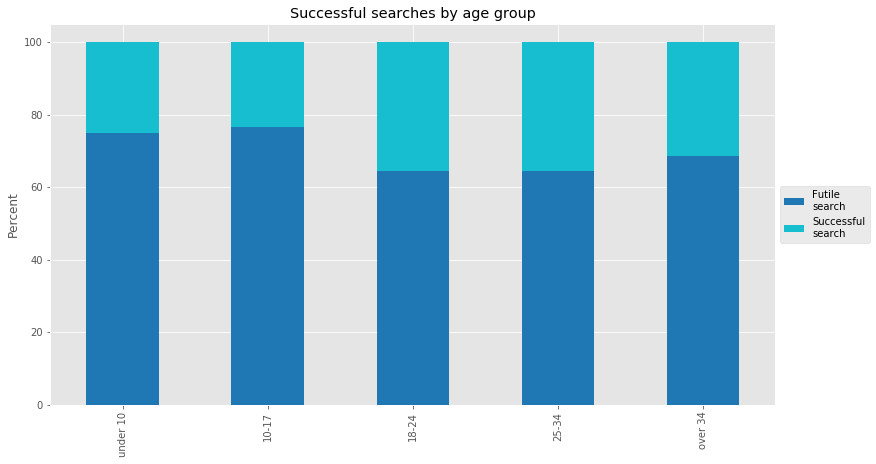

In [7]:
d = df_percent
fig = plt.gcf()
fig.set_size_inches(13, 7)

plt.title('Successful searches by age group', color = 'black')
d.plot(kind = 'bar',
       stacked = True,
       ax = fig.gca(),
       colormap = 'tab10')

plt.legend(loc = 'center left',
           bbox_to_anchor = (1, 0.5),
           labels = ('Futile\nsearch',
                     'Successful\nsearch'))

plt.ylabel('Percent')
plt.show()

In [8]:
df_age = pd.DataFrame(df['age_range'].value_counts())
df_age.loc['total'] = df_age.sum(axis=0)
df_age['percentage'] = df_age.loc[:]/df_age.loc['total']*100
df_age

,age_range,percentage
18-24,252150,37.430361
25-34,158611,23.544981
10-17,136474,20.258858
over 34,126048,18.711172
under 10,368,0.054628
total,673651,100.000000


In [9]:
df_gender = pd.DataFrame(df['gender'].value_counts())
df_gender.loc['total'] = df_gender.sum(axis=0)
df_gender['percentage'] = df_gender.loc[:]/df_gender.loc['total']*100
df_gender

,gender,percentage
Male,618198,91.768290
Female,55044,8.170997
Other,409,0.060714
total,673651,100.000000


In [10]:
df_ethn = pd.DataFrame(df['officer_defined_ethnicity'].value_counts())
df_ethn.loc['total'] = df_ethn.sum(axis=0)
df_ethn['percentage'] = df_ethn.loc[:]/df_ethn.loc['total']*100
df_ethn

,officer_defined_ethnicity,percentage
White,398090,59.094398
Black,174490,25.902136
Asian,82014,12.174553
Other,18060,2.680913
Mixed,997,0.147999
total,673651,100.000000


In [11]:
df_suc = pd.DataFrame(df['success'].value_counts())
df_suc.loc['total'] = df_suc.sum(axis=0)
df_suc['percentage'] = df_suc.loc[:]/df_suc.loc['total']*100
df_suc

,success,percentage
False,456591,67.778568
True,217060,32.221432
total,673651,100.000000


In [12]:
df_hour = pd.DataFrame(df['hour'].value_counts())
df_hour.loc['total'] = df_hour.sum(axis=0)
df_hour['percentage'] = df_hour.loc[:]/df_hour.loc['total']*100
df_hour

,hour,percentage
23,57547,8.542554
0,49022,7.277062
16,44944,6.671704
15,44622,6.623905
17,40260,5.976388
14,39156,5.812505
20,38832,5.764409
22,37587,5.579595
19,36815,5.464996
21,36441,5.409478


In [13]:
df_percent

success,False,True
under 10,75.000000,25.000000
10-17,76.681273,23.318727
18-24,64.589728,35.410272
25-34,64.602077,35.397923
over 34,68.494542,31.505458


In [14]:
# Crosstab with "normalize = 'index'". 
df_percent_success = pd.crosstab(df.officer_defined_ethnicity,
                                 df.age_range,
                                 normalize = 'index').rename_axis(None)

# Multiply all percentages by 100 for graphing. 
df_percent_success *= 100
df_percent_success['total'] = df_percent_success.sum(axis=1)
df_percent_success

age_range,10-17,18-24,25-34,over 34,under 10,total
Asian,14.412174,48.846538,25.105470,11.612651,0.023167,100.0
Black,24.029457,41.788068,20.528397,13.613388,0.040690,100.0
Mixed,25.376128,37.913741,25.075226,11.434303,0.200602,100.0
Other,20.537099,44.667774,21.998893,12.740864,0.055371,100.0
White,19.785224,32.838805,24.612022,22.697129,0.066819,100.0


In [15]:
# Crosstab with "normalize = 'index'". 
df_percent_success = pd.crosstab(df.officer_defined_ethnicity,
                                 df.gender,
                                 normalize = 'index').rename_axis(None)

# Multiply all percentages by 100 for graphing. 
df_percent_success *= 100
df_percent_success['total'] = df_percent_success.sum(axis=1)
df_percent_success

gender,Female,Male,Other,total
Asian,3.003146,96.921257,0.075597,100.0
Black,4.701129,95.256462,0.042409,100.0
Mixed,8.625878,91.374122,0.000000,100.0
Other,4.479513,95.404208,0.116279,100.0
White,10.922907,89.013791,0.063302,100.0


In [16]:
# Crosstab with "normalize = 'index'"
df_percent_success = pd.crosstab(df.age_range,
                                 df.gender,
                                 normalize = 'index').rename_axis(None)

# Multiply all percentages by 100 for graphing. 
df_percent_success *= 100
df_percent_success['total'] = df_percent_success.sum(axis=1)
df_percent_success

gender,Female,Male,Other,total
10-17,7.698902,92.239547,0.061550,100.0
18-24,6.667063,93.271862,0.061075,100.0
25-34,8.753491,91.184722,0.061786,100.0
over 34,10.952970,88.990702,0.056328,100.0
under 10,9.782609,89.673913,0.543478,100.0


In [17]:
df['success'].value_counts()

False    456591
True     217060
Name: success, dtype: int64

In [18]:
df['success'].mean()*100

32.221432165913804

# 7. Choropleth

In [19]:
# Load essentials
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

**Note:** Download shapefile and other geospatial data from [our GitHub repo](https://github.com/mathiasbruun/SDS19-Exam-Project).

In [20]:
# Load shapefile
fp = 'Local_Authority_Districts_December_2017_Super_Generalised_Clipped_Boundaries_in_Great_Britain.shp'

map_df = gpd.read_file(fp)

In [21]:
map_df.head()

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.365265e+07,59467.502291,"POLYGON ((447851.2015000004 537036.0043000001,..."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.410254e+07,38474.532954,(POLYGON ((450791.1017000005 520932.5039000008...
2,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.447601e+08,90579.304692,(POLYGON ((456987.1991999997 526324.9002999999...
3,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.043652e+08,102708.184772,"POLYGON ((445397.8010999998 526934.3958999999,..."
4,5,E06000005,Darlington,None,428029,515649,-1.56835,54.535351,1.977901e+08,97801.401117,"POLYGON ((423240.1971000005 524970.8979000002,..."


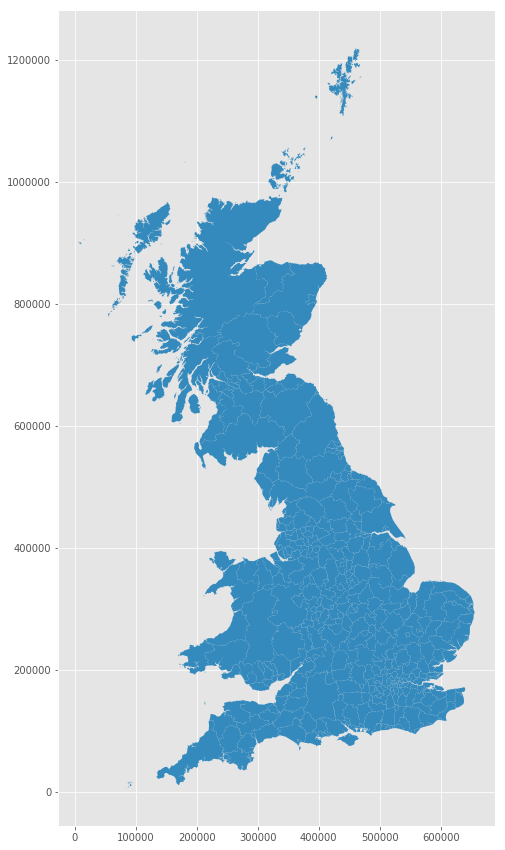

In [22]:
# Inspect full map
map_df.plot(figsize = (15, 15))

In [23]:
# Load main dataset (including LA codes)
url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/Data_with_mean_income_population.zip'
Data = pd.read_csv(url, compression='zip', na_values='NaN', low_memory = False)

df = Data.copy()
df.columns
df = df.loc[:,['age_range', 'gender', 'object_of_search', 'officer_defined_ethnicity', 
               'type','Force','hour', 'month', 'outcome', 'nearest_local_auth']]

df = df.dropna()

df.head(5)

,age_range,gender,object_of_search,officer_defined_ethnicity,type,Force,hour,month,outcome,nearest_local_auth
0,18-24,Female,Controlled drugs,White,Person search,avon-and-somerset,3,7,Suspect summonsed to court,E06000023
1,18-24,Female,Controlled drugs,White,Person search,avon-and-somerset,3,7,False,E06000023
2,18-24,Female,Controlled drugs,White,Person search,avon-and-somerset,3,7,False,E06000023
3,10-17,Male,Articles for use in criminal damage,White,Person search,avon-and-somerset,5,7,False,E07000190
4,25-34,Male,Stolen goods,Other,Person search,avon-and-somerset,7,7,False,E07000187


In [24]:
# Define 'failure' and 'success' columns
df['failure'] = df.loc[:,'outcome'].isin(['A no further action disposal', 'False']).astype(float)
df['success'] = df.loc[:,'outcome'].isin(['Suspect arrested',
                                          'Arrest',
                                          'Offender given drugs possession warning',
                                          'Khat or Cannabis warning',
                                          'Local resolution',
                                          'Article found - Detailed outcome unavailable',
                                          'Summons / charged by post',
                                          'Penalty Notice for Disorder',
                                          'Offender given penalty notice',
                                          'Caution (simple or conditional)',
                                          'Offender cautioned',
                                          'Suspected psychoactive substances seized - No further action']).astype(float)

# Aggregate observations by Local Authority code and calculate percentage of failures / successes respectively
df_outcomes = pd.pivot_table(df, values = ['failure', 'success'], index = 'nearest_local_auth', aggfunc = np.sum)
df_outcomes['total'] = df_outcomes.sum(axis = 1)
df_outcomes['proportion_failure'] = (df_outcomes['failure'] / df_outcomes['total']) * 100
df_outcomes['proportion_success'] = (df_outcomes['success'] / df_outcomes['total']) * 100
print(df_outcomes)
df_outcomes = df_outcomes[df_outcomes['total'] > 100]
print(df_outcomes)
df_outcomes.tail()

                    failure  success    total  proportion_failure  \
nearest_local_auth                                                  
E06000001             267.0    145.0    412.0           64.805825   
E06000002             570.0    284.0    854.0           66.744731   
E06000003             101.0     60.0    161.0           62.732919   
E06000004             263.0    167.0    430.0           61.162791   
E06000005             921.0    577.0   1498.0           61.481976   
E06000006             782.0    396.0   1178.0           66.383701   
E06000007             559.0    341.0    900.0           62.111111   
E06000008             499.0    135.0    634.0           78.706625   
E06000009            1544.0    420.0   1964.0           78.615071   
E06000010             460.0    117.0    577.0           79.722704   
E06000011              13.0      4.0     17.0           76.470588   
E06000012             215.0     48.0    263.0           81.749049   
E06000013             180.0     48

,failure,success,total,proportion_failure,proportion_success
nearest_local_auth,,,,,
W06000018,171.0,42.0,213.0,80.281690,19.718310
W06000019,142.0,22.0,164.0,86.585366,13.414634
W06000020,270.0,46.0,316.0,85.443038,14.556962
W06000022,717.0,61.0,778.0,92.159383,7.840617
W06000024,188.0,43.0,231.0,81.385281,18.614719


In [25]:
# Quick testing / inspection – compare with official maps to make sure that LA codes and areas correspond
df_outcomes.loc['E09000023']
df_outcomes.loc['S12000028']
df_outcomes = df_outcomes.drop('S12000028') # Remove "Scottish" obs

In [26]:
# Join GeoDataFrame with outcome dataset
merged = map_df.set_index('lad17cd').join(df_outcomes, how = 'inner')
merged['proportion_success'].describe()

count    298.000000
mean      28.693632
std        6.022848
min        7.840617
25%       25.000000
50%       28.483910
75%       32.230643
max       50.648228
Name: proportion_success, dtype: float64

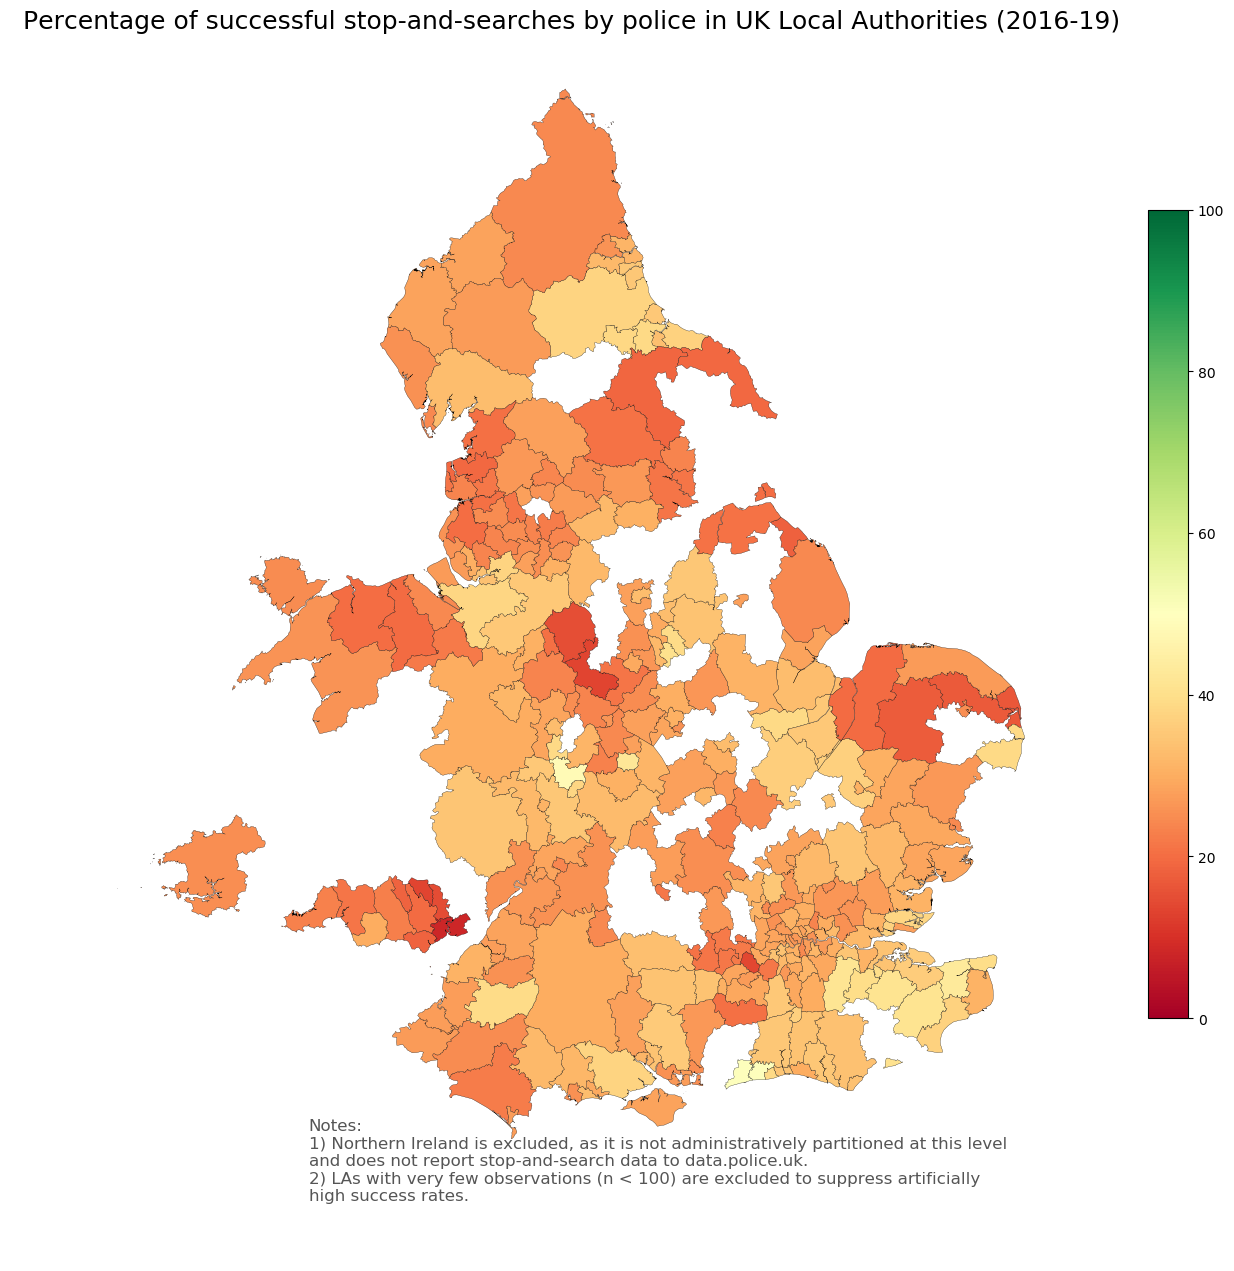

In [27]:
plt.style.use('default')

# Variable to plot
variable = 'proportion_success'

# Choropleth min / max
vmin, vmax = 0, 100

# Set up figure and axes
fig, ax = plt.subplots(1, figsize = (20, 15))

# Create map
merged.plot(column = variable,
            cmap = 'RdYlGn',
            linewidth = 0.2,
            ax = ax,
            edgecolor = '0',
            vmin = vmin,
            vmax = vmax)

# Remove axis and add title
ax.axis('off')

ax.set_title('Percentage of successful stop-and-searches by police in UK Local Authorities (2016-19)',
             fontdict = {'fontsize': '18',
                         'fontweight' : '3'})

# Set up colorbar
sm = plt.cm.ScalarMappable(cmap = 'RdYlGn',
                           norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm, shrink = 0.7)

ax.annotate('Notes:\n1) Northern Ireland is excluded, as it is not administratively partitioned at this level\nand does not report stop-and-search data to data.police.uk.\n2) LAs with very few observations (n < 100) are excluded to suppress artificially\nhigh success rates.',
            xy = (0.25, .12),
            xycoords = 'figure fraction',
            horizontalalignment = 'left',
            verticalalignment = 'top',
            fontsize = 12,
            color = '#555555')

# Save map
fig.savefig('percentage_successful_searches_entire_UK (red-to-green).png', dpi = 100)

#  8. Machine Learning Script

## Importing Packages

In [2]:
#Import different packages
import requests,os,time
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as scores
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

## Preparing Data and Plot Settings

In [3]:
url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/16_19_data_with_local_auth_time.zip'
Data = pd.read_csv(url, compression='zip', na_values='NaN', low_memory=False)

In [4]:
#Plot settings
plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
Data.columns

Index(['age_range', 'datetime', 'gender', 'involved_person', 'legislation',
       'object_of_search', 'officer_defined_ethnicity', 'operation',
       'operation_name', 'outcome', 'outcome_linked_to_object_of_search',
       'removal_of_more_than_outer_clothing', 'self_defined_ethnicity', 'type',
       'Force', 'latitude', 'street_name', 'street_id', 'longitude',
       'outcome_object_id', 'outcome_object_name', 'nearest_local_auth',
       'month', 'hour', 'Night_dummy'],
      dtype='object')

In [6]:
#Create dataframe with relevant variables
Df = Data.copy()
Df.set_index('datetime', drop = True, inplace=True)
#Define succes variable
Df['succes'] = ~Df.loc[:,'outcome'].isin(['A no further action disposal', 'False'])
#Slice features for model
Df = Df.loc[:,['age_range', 'gender', 'object_of_search', 'officer_defined_ethnicity', 
               'type', 'succes','Force','hour', 'month']]
#Make month and hour string so they can be converted to dummy variables
Df['month'] = Df['month'].astype(str)
Df['hour'] = Df['hour'].astype(str)
Df = Df.dropna()
Df.head(3)

,age_range,gender,object_of_search,officer_defined_ethnicity,type,succes,Force,hour,month
datetime,,,,,,,,,
2016-07-01 03:36:40+00:00,18-24,Female,Controlled drugs,White,Person search,True,avon-and-somerset,3,7
2016-07-01 03:36:40+00:00,18-24,Female,Controlled drugs,White,Person search,False,avon-and-somerset,3,7
2016-07-01 03:36:40+00:00,18-24,Female,Controlled drugs,White,Person search,False,avon-and-somerset,3,7


In [6]:
print(len(Df))
Variables = pd.DataFrame(Df.columns, columns=['Variables']).drop(5, axis=0)
Variables = Variables.reset_index(drop=True)
Variables

673651


,Variables
0,age_range
1,gender
2,object_of_search
3,officer_defined_ethnicity
4,type
5,Force
6,hour
7,month


In [7]:
#Create dummies -> mean_income and mean_population will not be converted
Df = pd.get_dummies(Df, drop_first=True)
Df['succes'] = Df['succes'].astype(int)
X = Df.drop('succes', axis = 1)
y = Df['succes']

In [8]:
#Check the mean outcome of the stops and searches
y.describe()
1-y.mean()

0.677785678340862

## Machine Learning Model

In [9]:
# split into development and test data
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

#Define lambdas
lambdas = np.logspace(-2, 2, 5)

# outer loop: lambdas
Accuracy = []

for lambda_ in tqdm(lambdas):    
    # inner loop: folds
    Accuracy_i = [] 
    for train_idx, val_idx in folds:        
        # train model and compute accuracy on test fold
        logr = make_pipeline(StandardScaler(), LogisticRegression(solver = 'lbfgs', C=lambda_, random_state=1, max_iter=200))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        logr.fit(X_train, y_train)        
        Accuracy_i.append(logr.score(X_val, y_val))      
        
    # store result    
    Accuracy.append(Accuracy_i)

    
# convert to DataFrame
lambdaCV = pd.DataFrame(Accuracy, index=lambdas)
lambdaCV

,0,1,2,3,4,5,6,7,8,9
0.01,0.679544,0.678431,0.679915,0.680862,0.680453,0.680175,0.679711,0.678895,0.680583,0.679155
0.10,0.679656,0.678394,0.679897,0.680862,0.680435,0.680157,0.679730,0.678932,0.680528,0.679117
1.00,0.679656,0.678394,0.679897,0.680862,0.680435,0.680157,0.679730,0.678932,0.680528,0.679117
10.00,0.679656,0.678394,0.679897,0.680862,0.680435,0.680157,0.679730,0.678932,0.680528,0.679117
100.00,0.679656,0.678394,0.679897,0.680862,0.680435,0.680157,0.679730,0.678932,0.680528,0.679117


In [10]:
#Optimal value
optimal_lambda = lambdaCV.mean(axis=1).nlargest(1)
print(optimal_lambda)
logr = make_pipeline(StandardScaler(), LogisticRegression(solver = 'lbfgs', C=optimal_lambda.index[0], random_state=1, max_iter=200)) 

# fit new model on all of the development (non-test) data
logr.fit(X_dev, y_dev)

#predict
y_hat = logr.predict(X_test)
#measure accuracy
accuracy = (y_hat==y_test).mean()
print('Model accuracy is:', np.round(accuracy,3))
score = logr.score(X_test, y_test)
print(score)

0.01    0.679773
dtype: float64
Model accuracy is: 0.682
0.6818252666424208


In [11]:
#Return coefficients
pd.DataFrame(logr.steps[1][1].coef_, columns=X.columns).T.head(3)

,0
age_range_18-24,0.237112
age_range_25-34,0.202823
age_range_over 34,0.130989


[[90050  1479]
 [41389  1813]]


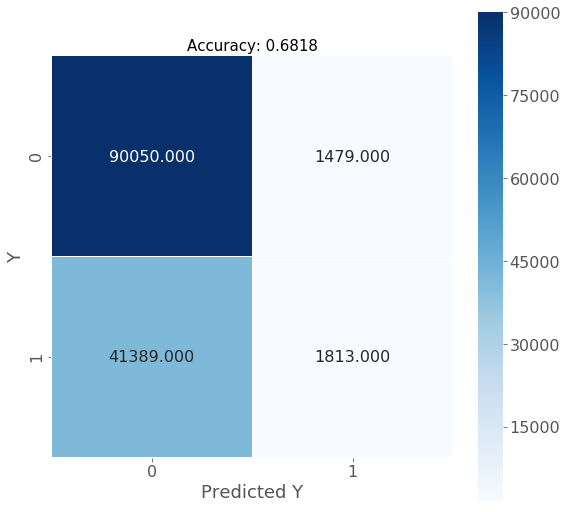

In [12]:
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
print(confusion_matrix)
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.1, square = True, cmap = 'Blues');
plt.ylabel('Y');
plt.xlabel('Predicted Y');
all_sample_title = 'Accuracy: {0:.4f}'.format(metrics.accuracy_score(y_test, y_hat))#\
# + '  Precision: {0:.4f},'.format(metrics.precision_score(y_test, y_hat))\
# + '  Recall: {0:.4f}'.format(metrics.recall_score(y_test, y_hat))
plt.title(all_sample_title, size = 15);
plt.savefig('confusion_matrix.png')

In [13]:
precision, recall, fscore, support = scores(y_test, y_hat)
array = (precision, recall, fscore, support)
columns = ['Failure', 'Succes']
index = ['Precision', 'Recall', 'F1', 'Support']
pd.DataFrame(array, index=index, columns=columns)

,Failure,Succes
Precision,0.685109,0.550729
Recall,0.983841,0.041966
F1,0.807739,0.077989
Support,91529.000000,43202.000000


In [14]:
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))
print("Precision:",metrics.precision_score(y_test, y_hat))
print("Recall:",metrics.recall_score(y_test, y_hat))

Accuracy: 0.6818252666424208
Precision: 0.5507290400972054
Recall: 0.041965649738438034


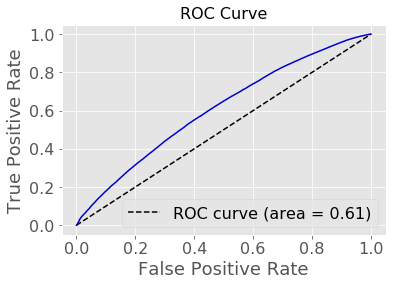

In [15]:
# Import necessary modules
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='ROC curve (area = %0.2f)' % roc_auc)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.plot(fpr, tpr, 'mediumblue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve.png')


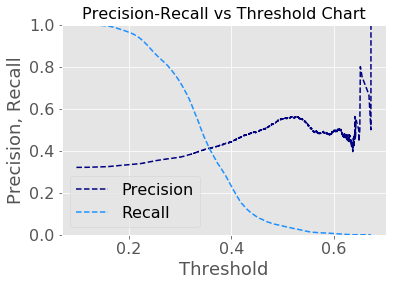

In [16]:
#Plot precision-recall curve
from sklearn.metrics import precision_recall_curve

y_pred_prob= logr.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)


roc_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "navy", linestyle='dashed', label="Precision")
plt.plot(thresholds, recall[: -1], "dodgerblue", linestyle='dashed' ,label="Recall")
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

plt.savefig('Precision-Recall_Threshold.png')

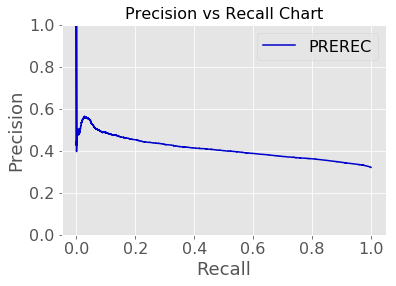

In [17]:
#Plot precision-recall curve
from sklearn.metrics import precision_recall_curve

y_pred_prob= logr.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)


roc_auc = auc(recall, precision)

plt.title("Precision vs Recall Chart")
plt.plot(recall[: -1], precision[: -1], "mediumblue", label="PREREC")
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="upper right")
plt.ylim([0,1])
plt.savefig('Precision-Recall.png')

In [18]:
auc(recall, precision)

0.40801337326275344

In [19]:
len(X.columns)


102

In [20]:
from pandas.plotting import table
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

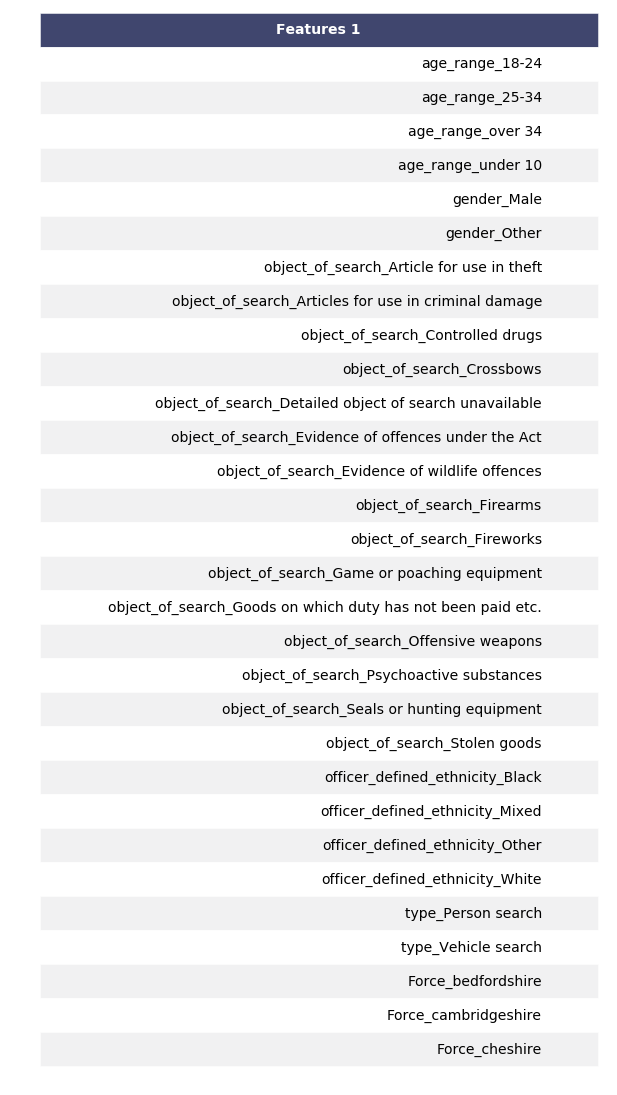

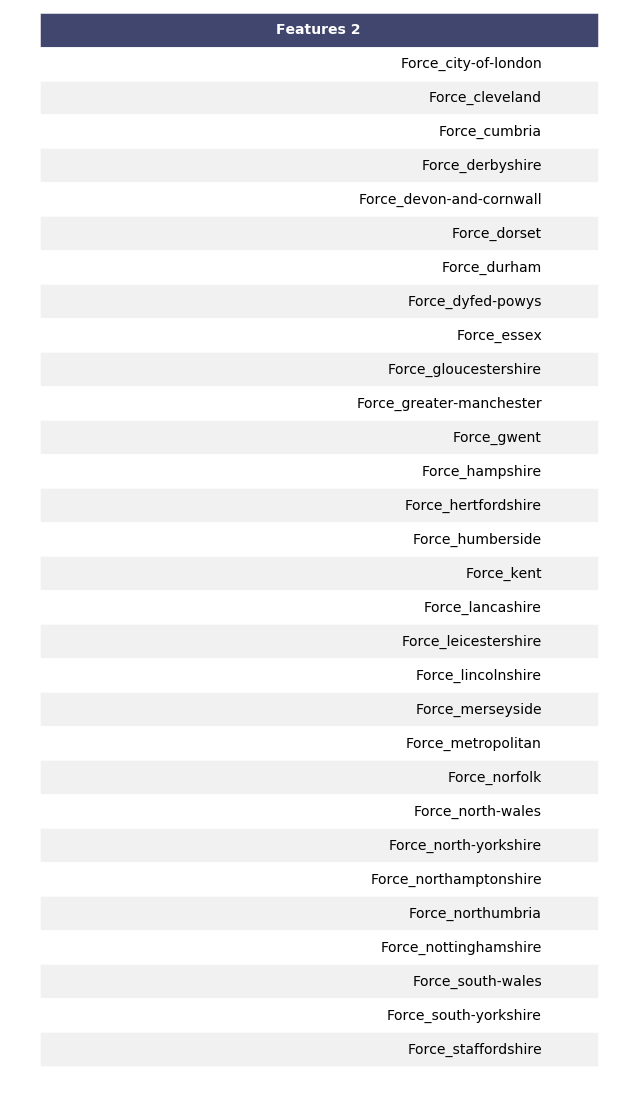

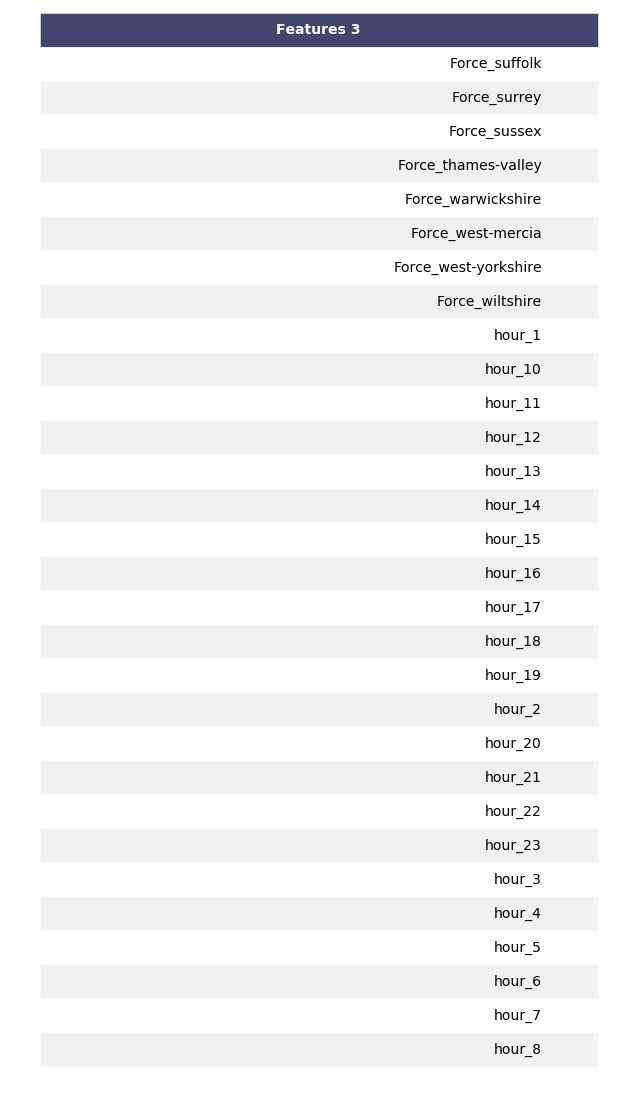

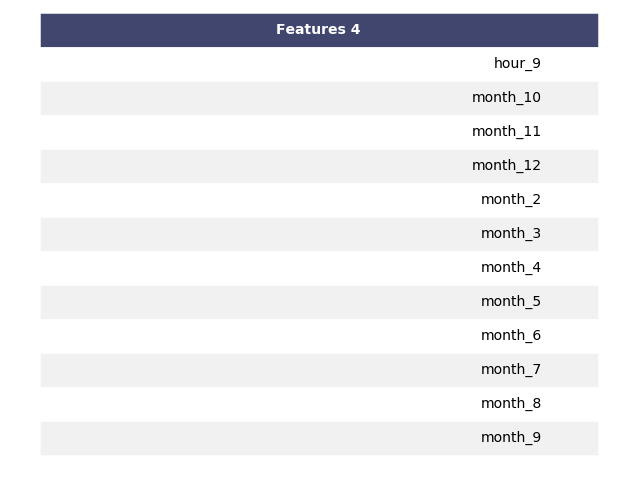

In [22]:
for i in range(0,101, 30):
    Features = pd.DataFrame(X.columns[i:(i+30)], columns=['Features '+str(i//30+1)]).reset_index(drop=True)
    render_mpl_table(Features, header_columns=0, col_width=10.0)
    Features.to_csv('Features '+str(i//30+1)+'.csv')
    plt.savefig('Features '+str(i//30+1)+'.png')